## 引入工具

In [318]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
# %watermark -p numpy,sklearn,pandas
# %watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
# %watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x):
    try: 
        x = x.strip()
        if x[0] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                uri = 'https://' + x
                x = requests.get(uri)
                if x.status_code == 200:
                    x = x.text
            elif x.startswith('github.com'):
                uri = x.replace('github.com', 'raw.githubusercontent.com')
                mod = uri.split('/')
                for s in ['main', 'master']:
                    uri = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[-3:])
                    x = requests.get(uri)
                    if x.status_code == 200:
                        x = x.text
                        break
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                for s in ['/raw/main/', '/raw/master/']:
                    uri = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[3:])
                    x = requests.get(uri)
                    if x.status_code == 200:
                        x = x.text
                        break
        exec(x, globals())
    except:
        pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)


## 解析配置

In [495]:
_IMPORT('/data/nb_easy/easy_widget.py')

In [496]:
from utils import oss_put_bytes

In [565]:
from utils import EVENTS

RACEURL = 'http://116.85.27.115:9119'
MSGKEY = 'nb.zmq.repnet_tf.gamma102'

with open('schema.json', 'r') as fr:
    schema_string = fr.read()
    schema_string = schema_string.replace('zmq.repnet_tf.test', MSGKEY)
    schema_string = schema_string.replace('http://host:port', RACEURL)
    schema = json.loads(schema_string)
easy = nbeasy_schema_parse(schema, events=EVENTS, debug=True);

Box(children=(Box(children=(VBox(children=(Tab(children=(VBox(children=(HBox(children=(Text(value='zmq.repnet_…

```
good: https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215151848/1639560131/target-stride.mp4
 bad: https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215151848/1639560742/target-stride.mp4
 
 
good: https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215135815/1639561097/target-stride.mp4
 bad: https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215135815/1639560903/target-stride.mp4
 
 
good: https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215140819/1639561609/target-stride.mp4 (beta: 0.9)
good: https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215140819/1639563724/target-stride.mp4 (beta: 0.7)
 bad: https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215140819/1639561712/target-stride.mp4
```

In [322]:
raise

RuntimeError: No active exception to reraise

1. https://frepai.s3.didiyunapi.com/datasets/vod/木槌加固/20211206123823.mp4

## Tools

In [ ]:
import numpy as np
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd
from sklearn import preprocessing

from matplotlib.colors import LogNorm
import itertools 
# axes = list(itertools.chain.from_iterable(axes))
from sklearn.manifold import Isomap

from scipy.signal import medfilt
import scipy.signal as signal
from statsmodels.distributions.empirical_distribution import ECDF
import pickle
import hashlib

In [ ]:
def _denormal_image(x):
    x -= x.mean()
    x /= x.std()
    x *= 64
    x += 128
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def outlier_detection(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data < lower_bound) | (data > upper_bound))

In [ ]:
def plot_scatter(data, colors=None):
    if len(data.shape) != 2:
        xs = range(len(data))
        ys = data
    else:
        if data.shape[1] == 1:
            ys = data[:, 0]
            xs = range(len(data))
        else:
            xs = data[:, 0]
            ys = data[:, 1]
        
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    ax.scatter(xs, ys, c=colors, edgecolor='none', cmap=plt.cm.get_cmap('Paired', 2))
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

In [ ]:
def draw_osd_sim(sim, size=128, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.axis('off')
    # fig.set_size_inches(size / 100.0, size / 100.0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.imshow(sim, cmap='hot', interpolation='nearest', norm=LogNorm())

In [ ]:
def moving_average(arr, axis=0, wsize=3):
    return np.apply_along_axis(lambda m: np.convolve(m, np.ones(wsize)/wsize, mode='same'), axis=axis, arr=arr)

def np_info(data):
    print('%.5f' % data.min(), '%.5f' % data.max(), '%.5f' % data.mean(), '%.5f' % data.std())

## Datasets

### Ladders

In [406]:
EMBS3_DIR = '/data/embs3'

In [567]:
%%bash

DST_DIR=/data/embs3

FILES=(
    # relu
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215113719/1639550847/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215114723/1639554095/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215142827/1639554367/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215153855/1639554991/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215154859/1639555546/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215131759/1639556353/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215112715/1639556674/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215174947/1639563979/embs_sims.npy'
    
    
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211208085922/1639557891/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211208082910/1639558131/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211209093126/1639558374/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211208111014/1639558546/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211207153832/1639558795/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211209185601/1640089727/embs_sims.npy'
    
    
    # elu
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215113719/1639566137/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215114723/1639567087/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215142827/1639567303/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215153855/1639567453/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215154859/1639567554/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215131759/1639567676/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215112715/1639567785/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215174947/1639568018/embs_sims.npy'
    
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211208085922/1639568399/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211208082910/1639568531/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211209093126/1639568754/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211208111014/1639568838/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211207153832/1639568947/embs_sims.npy'
    
    
    # neg
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211215/outputs/20211215140819/1639569655/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/live/00232ee8876d/20211215/outputs/20211215184945/1639570196/embs_sims.npy'
)

for file_ts in ${FILES[@]}
do
    if [[ ${file_ts:0:8} == 'https://' ]]
    then
        if [[ $file_ts =~ 'vod' ]]
        then
            file=`echo ${file_ts:8} | cut -d/ -f6`
        else
            file=`echo ${file_ts:8} | cut -d/ -f7`
        fi
        if [[ ! -f $DST_DIR/${file}_feat.npy ]]
        then
            echo $DST_DIR/${file}_feat.npy $file_ts
            wget -q -P $DST_DIR $file_ts
            echo $DST_DIR/${file}_sims.npy ${file_ts/sims.npy/feat.npy}
            wget -q -P $DST_DIR ${file_ts/sims.npy/feat.npy}
            mv $DST_DIR/embs_feat.npy $DST_DIR/${file}_feat.npy
            mv $DST_DIR/embs_sims.npy $DST_DIR/${file}_sims.npy
        fi
    fi
done

/data/embs3/1640089727_feat.npy https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211209185601/1640089727/embs_sims.npy
/data/embs3/1640089727_sims.npy https://frepai.s3.didiyunapi.com/datasets/vod/outputs/20211209185601/1640089727/embs_feat.npy


#### Pos Datasets

In [569]:
# relu
pos_embs_files1 = (
    ('1639550847', 0, 2),
    ('1639554095', 0, 4),
    ('1639554367', 0, 4),
    ('1639554991', 0, 3),
    ('1639555546', 4, 6),
    ('1639556353', 0, 5),
    ('1639556674', 0, 4),
    ('1639563979', 0, 5),
)

pos_embs_files2 = (
    ('1639557891', 0, 4),
    ('1639558131', 0, 5),
    ('1639558374', 0, 3),
    ('1639558546', 0, 10),
    ('1639558795', 0, 6),
    ('1640089727', 0, 7),
)

pos_embs_files3 = (
    ('1639566137', 0, 2),
    ('1639567087', 0, 4),
    ('1639567303', 0, 4),
    ('1639567453', 0, 3),
    ('1639567554', 0, 3),
    ('1639567554', 4, 6),
    ('1639567676', 0, 4),
    ('1639567785', 0, 5),
    ('1639568018', 0, 6),
)

pos_embs_files4 = (
    ('1639568399', 0, 1),
    ('1639568531', 0, 5),
    ('1639568754', 0, 3),
    ('1639568838', 0, 9),
    ('1639568947', 0, 6),
)


pos_embs_files = pos_embs_files1 + pos_embs_files2
# pos_embs_files = pos_embs_files3 + pos_embs_files4

print('len = %d' % len(pos_embs_files))

pos_feat_list = []
for e, pos1, pos2 in pos_embs_files:
    pos_feat_list.append(np.load(f'{EMBS3_DIR}/{e}_feat.npy')[pos1: pos2])
    
pos_feat_np = np.concatenate(pos_feat_list, axis=0)
pos_feat_np.shape

len = 14


(64, 64, 512)

In [571]:
#### eNeg Datasets

neg_embs_files1 = (
    '1639569655',
    '1639570196',
)

neg_embs_list = []
for e in neg_embs_files1:
    neg_embs_list.append((np.load(f'{EMBS3_DIR}/{e}_feat.npy'), np.load(f'{EMBS3_DIR}/{e}_sims.npy')))

### Office

In [401]:
EMBS2_DIR = '/data/embs2'

In [392]:
%%bash

DST_DIR=/data/embs2
URL_PREFIX=https://frepai.s3.didiyunapi.com/datasets/office/outputs

FILES=(
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_001/1639375702/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_002/1639376328/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_003/1639377064/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_004/1639378388/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_005/1639379023/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/test_001/1639379368/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/test_002/1639380071/embs_sims.npy'
    
    
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_001/1639381130/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_002/1639381266/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_003/1639381312/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_004/1639381364/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/pencil_sharpener_005/1639381425/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/test_001/1639381475/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/test_002/1639381535/embs_sims.npy'
    
    
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/test2_001/1639382370/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/office/outputs/test2_002/1639382558/embs_sims.npy'
)

for file_ts in ${FILES[@]}
do
    if [[ ${file_ts:0:8} == 'https://' ]]
    then
        file=`echo ${file_ts:8} | cut -d/ -f6`
        if [[ ! -f $DST_DIR/${file}_feat.npy ]]
        then
            file=`echo ${file_ts:8} | cut -d/ -f6`
            echo $DST_DIR $file_ts
            wget -q -P $DST_DIR $file_ts
            echo $DST_DIR ${file_ts/sims.npy/feat.npy}
            wget -q -P $DST_DIR ${file_ts/sims.npy/feat.npy}
            mv $DST_DIR/embs_feat.npy $DST_DIR/${file}_feat.npy
            mv $DST_DIR/embs_sims.npy $DST_DIR/${file}_sims.npy
        fi
    else
        file=`echo $file_ts | cut -d/ -f1`
        if [[ ! -f $DST_DIR/${file}_feat.npy ]]
        then
            echo $DST_DIR $URL_PREFIX/$file_ts/embs_sims.npy
            wget -q -P $DST_DIR $URL_PREFIX/$file_ts/embs_sims.npy
            echo $DST_DIR $URL_PREFIX/$file_ts/embs_feat.npy
            wget -q -P $DST_DIR $URL_PREFIX/$file_ts/embs_feat.npy
            mv $DST_DIR/embs_feat.npy $DST_DIR/${file}_feat.npy
            mv $DST_DIR/embs_sims.npy $DST_DIR/${file}_sims.npy
        fi
    fi
done

#### Pos Datasets

In [407]:
# relu
pos_embs_files = (
    '1639375702',
    '1639376328',
    '1639377064',
    '1639378388',
    '1639379023',
)

In [404]:
# elu
pos_embs_files2 = (
    '1639381130',
    '1639381266',
    '1639381312',
    '1639381364',
    '1639381425',
)

In [408]:
pos_feat_list = []
for s in pos_embs_files:
    pos_feat_list.append(np.load(f'{EMBS_DIR}/{s}_feat.npy'))
    
pos_feat_np = np.concatenate(pos_feat_list, axis=0)
pos_feat_np.shape

(70, 64, 512)

In [121]:
pos_sims_list = []
for s in pos_embs_files:
    pos_sims_list.append(np.load(f'{EMBS_DIR}/{s}_sims.npy')[1:-1])
    
pos_sims_np = np.vstack(pos_sims_list)
pos_sims_np.shape

(103, 64, 64)

#### Neg Datasets

In [ ]:
neg_embs_files = (
    '1639379368',
    '1639380071',
)

In [ ]:
neg_embs_files2 = (
    '1639381475',
    '1639381535',
)

In [ ]:
# misc
neg_embs_files3 = (
    '1639382370',
    '1639382558',
)

In [ ]:
neg_feat_list = []
for s in neg_embs_files3:
    neg_feat_list.append(np.load(f'{EMBS_DIR}/{s}_feat.npy'))
    
neg_feat_np = np.vstack(neg_feat_list)
neg_feat_np.shape

### Hands

In [416]:
EMBS1_DIR = '/data/embs1'

In [ ]:
# https://frepai.s3.didiyunapi.com/datasets/weights/855ce06bbb50.pkl
# https://frepai.s3.didiyunapi.com/datasets/weights/d0854f5eb6ea.pkl

In [486]:
%%bash

DST_DIR=/data/embs1

FILES=(
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/hand_click_01/1639742472/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/hand_click_02/1639742553/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/hand_click_03/1639742668/embs_sims.npy'
    
    
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/hand_click_05/1639744514/embs_sims.npy'
    'https://frepai.s3.didiyunapi.com/datasets/vod/outputs/hand_click_07/1639744553/embs_sims.npy'
)

for file_ts in ${FILES[@]}
do
    if [[ ${file_ts:0:8} == 'https://' ]]
    then
        if [[ $file_ts =~ 'vod' ]]
        then
            file=`echo ${file_ts:8} | cut -d/ -f6`
        else
            file=`echo ${file_ts:8} | cut -d/ -f7`
        fi
        if [[ ! -f $DST_DIR/${file}_feat.npy ]]
        then
            echo $DST_DIR/${file}_feat.npy $file_ts
            wget -q -P $DST_DIR $file_ts
            echo $DST_DIR/${file}_sims.npy ${file_ts/sims.npy/feat.npy}
            wget -q -P $DST_DIR ${file_ts/sims.npy/feat.npy}
            mv $DST_DIR/embs_feat.npy $DST_DIR/${file}_feat.npy
            mv $DST_DIR/embs_sims.npy $DST_DIR/${file}_sims.npy
        fi
    fi
done

#### Pos Datasets

In [487]:
pos_embs_files = (
    ('1639742472', 0, 3),
    ('1639742553', 0, 3),
    ('1639742668', 0, 2),
)

pos_feat_list = []
for emb, s, e in pos_embs_files:
    feat = np.load(f'{EMBS1_DIR}/{emb}_feat.npy')
    if e:
        pos_feat_list.append(feat[s:e])
    else:
        pos_feat_list.append(feat[s:])
    
pos_feat_np = np.concatenate(pos_feat_list, axis=0)
pos_feat_np.shape

(8, 64, 512)

#### Test Datasets

In [488]:
test_embs_files = (
    ('1639744514', 0, None),
    ('1639744553', 0, None),
)

test_feat_list = []
for emb, s, e in test_embs_files:
    feat = np.load(f'{EMBS1_DIR}/{emb}_feat.npy')
    if e:
        test_feat_list.append(feat[s:e])
    else:
        test_feat_list.append(feat[s:])
    
test_feat_np = np.concatenate(test_feat_list, axis=0)
test_feat_np.shape

(7, 64, 512)

### KSTest

In [599]:
scaler1 = preprocessing.StandardScaler()
scaler2 = preprocessing.MinMaxScaler()
scaler3 = preprocessing.RobustScaler(quantile_range=(25., 75.))
scaler4 = preprocessing.Normalizer()
scaler5 = preprocessing.MaxAbsScaler()
NC = 200
pca = PCA(n_components=NC)
# ios = Isomap(n_components=NC)
# tril = np.tril_indices(64)
# tsne = TSNE(n_components=2, random_state=0)

In [600]:
data_feat = pos_feat_np.copy()
data = data_feat.reshape((-1, 512))

cdata = data.copy()
scaler = scaler4

kspca = pca

# filter_func = lambda x: moving_average(x, wsize=3)
# filter_func = lambda x: signal.medfilt2d(x, kernel_size=(3,1))
# filter_func = lambda x: np.diff(x, axis=0, prepend=0)
filter_func = lambda x: x

cdata = filter_func(cdata)

scaler.fit(cdata)
data_out = kspca.fit_transform(scaler.transform(cdata))

ecdfs = [ECDF(sample) for sample in data_out.T]

# print(kspca.explained_variance_ratio_)

def empirical_kstest(test, ecdfs, alpha=0.01):
    pvals = np.array([stats.kstest(test[:, i], cdf=lambda x: ecdfs[i](x))[1] for i in range(test.shape[-1])])
    return sum(kspca.explained_variance_ratio_[pvals > alpha])
    # return np.mean(pvals > alpha)
    
sum(kspca.explained_variance_ratio_) / 2, sum(kspca.explained_variance_ratio_)

(0.45988875135662965, 0.9197775027132593)

### A

In [ ]:
def draw_emb_feat(emb64):
    out64 = kspca.transform(scaler.transform(emb64))
    out64 = scaler2.fit_transform(out64).reshape((-1, 10, 10))
    fig, axes = plt.subplots(8, 8, figsize=(18, 18), sharex=True, sharey=True)
    axes = list(itertools.chain.from_iterable(axes))
    for i in range(len(axes)):
        axes[i].set_title('%.4f %.4f' % (out64[i].mean(), np.sqrt(out64[i].var())))
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].imshow(out64[i])

In [ ]:
# embs, sims = neg_embs_list[0]
# for embs in pos_feat_list:
#     for f in embs:
#         f = filter_func(f)
#         out = scaler.transform(f)
#         print('%.6f' % empirical_kstest(out, ecdf), end='\t')
#     print('')

In [ ]:
embs = np.load(f'{EMBS3_DIR}/1639568018_feat.npy')
draw_emb_feat(embs[0])

In [ ]:
sims = np.load(f'{EMBS3_DIR}/1639568018_sims.npy')
draw_osd_sim(sims[0])

In [ ]:
def draw_emb(emb64):
    out64 = kspca.transform(scaler.transform(emb64))
    out64 = scaler2.fit_transform(out64).reshape((-1, 10, 10))
    fig, axes = plt.subplots(8, 8, figsize=(18, 18), sharex=True, sharey=True)
    axes = list(itertools.chain.from_iterable(axes))
    for i in range(len(axes)):
        axes[i].set_title('%.4f %.4f' % (out64[i].mean(), np.sqrt(out64[i].var())))
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].imshow(out64[i])

## Save PKL

In [584]:
ksmodel = {
    'pca': kspca,
    'scaler': scaler,
    'ecdfs': ecdfs,
    'thresh': sum(kspca.explained_variance_ratio_) / 2
}

pcaks_pkl_path = '/data/ksmodel.pkl'

with io.BytesIO() as bio:
    pickle.dump(ksmodel, bio)
    md5 = hashlib.md5(bio.getvalue()).hexdigest()[:12]
    oss_put_bytes(bio.getvalue(), f'datasets/weights/{md5}.pkl')
    print(f'https://frepai.s3.didiyunapi.com/datasets/weights/{md5}.pkl')

https://frepai.s3.didiyunapi.com/datasets/weights/8036a1176168.pkl


In [601]:
for embs in pos_feat_list:
# for embs in test_feat_list:
    print('')
    for f in embs:
        f = filter_func(f)
        out = kspca.transform(scaler.transform(f))
        print('%.6f' % empirical_kstest(out, ecdfs), end='\t')


0.547249	0.466874	
0.452788	0.484677	0.451548	0.564136	
0.516956	0.535458	0.599051	0.599372	
0.628707	0.509222	0.486339	
0.587016	0.581899	
0.583823	0.575373	0.589460	0.458669	0.320901	
0.514001	0.441079	0.527204	0.497922	
0.509464	0.560292	0.544962	0.527822	0.493398	
0.715021	0.728157	0.689258	0.642012	
0.487183	0.515291	0.463459	0.627897	0.573901	
0.723615	0.572601	0.725203	
0.506872	0.492929	0.535610	0.573398	0.592495	0.541056	0.534129	0.624367	0.611577	0.560473	
0.559299	0.599468	0.603472	0.554704	0.487701	0.598170	
0.573698	0.458845	0.424528	0.508827	0.568344	0.411149	0.586324	

0.042918	0.252602	0.024463	0.026467	0.213217	0.042485	0.219586	0.224200	0.212353	0.211153	0.208839	0.207735	0.049630	0.031911	

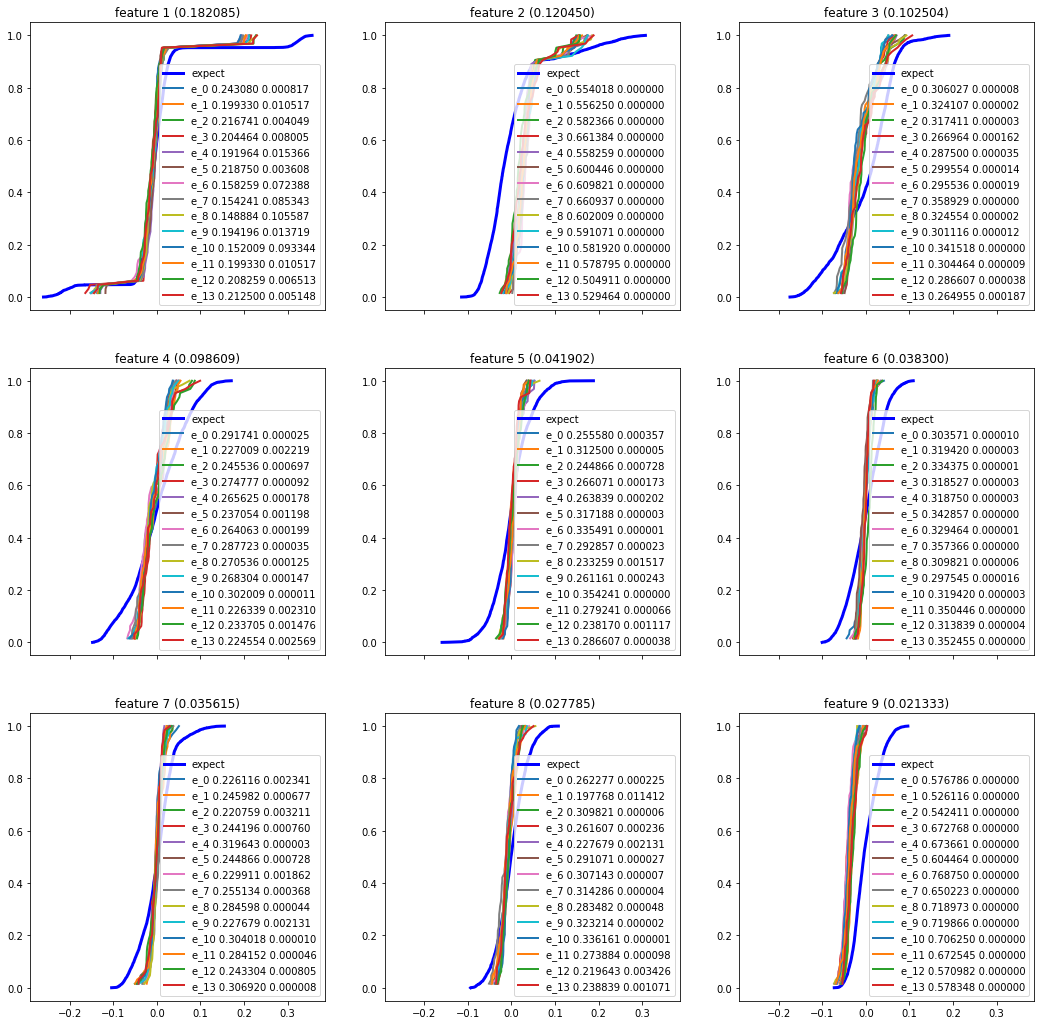

In [402]:
  
# draw_osd_sim(np.concatenate(sims, axis=1), figsize=(sims.shape[0] * 4, 8))

fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex=True)
axes = list(itertools.chain.from_iterable(axes))
for i in range(len(axes)):
    axes[i].set_title('feature %d (%.6f)' % (i + 1, kspca.explained_variance_ratio_[i]))
    axes[i].plot(ecdf[i].x, ecdf[i].y, color='b', lw=3, label='expect');
    for j in range(embs.shape[0]):
        label = f'e_{j}'
        out = kspca.transform(scaler.transform(embs[j]))
        cdf = ECDF(out.T[i])
        statistic, pvalue = stats.kstest(out.T[i], cdf=lambda x: ecdf[i](x))
        axes[i].plot(cdf.x, cdf.y, lw=2, label='%s %.6f %.6f'%(label, statistic, pvalue));
    axes[i].legend();

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 18), sharex=True)
axes = list(itertools.chain.from_iterable(axes))
for i in range(len(axes)):
    axes[i].set_title('feature %d (%.6f)' % (i + 1, kspca.explained_variance_ratio_[i]))
    axes[i].plot(ecdf[i].x, ecdf[i].y, color='b', lw=3, label='global');
    for label, feat in (('good', pos_feat_list[0]), ('bad', neg_feat_list[-1])):
        out = kspca.transform(scaler.transform(feat[1]))
        cdf = ECDF(out.T[i])
        statistic, pvalue = stats.kstest(out.T[i], cdf=lambda x: ecdf[i](x))
        axes[i].plot(cdf.x, cdf.y, lw=2, label='%s %.6f %.6f'%(label, statistic, pvalue));
    axes[i].legend();

In [ ]:
for feat in pos_feat_list[-2:] + neg_feat_list:
    print('')
    for f in feat[1:-1]:
        f = filter_func(f)
        out = kspca.transform(scaler.transform(f))
        print('%.6f' % empirical_kstest(out, ecdf), end='\t')
    print('')

In [ ]:
for feat in (feat_np_922, feat_np_905, feat_np_601):
    print('')
    for f in feat:
        f = filter_func(f)
        out = kspca.transform(scaler.transform(f))
        print('%.6f' % empirical_kstest(out, ecdf), end='\t')

In [ ]:
for feat in (feat_np_855, feat_np_313):
    print('')
    for f in feat:
        f = filter_func(f)
        out = kspca.transform(scaler.transform(f))
        print('%.6f' % empirical_kstest(out, ecdf), end='\t')

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.plot(
    kspca.explained_variance_ratio_, "--o", linewidth=2,
    label="Explained variance ratio"
)
ax.plot(
    kspca.explained_variance_ratio_.cumsum(), "--o", linewidth=2,
    label="Cumulative explained variance ratio"
)

ax.legend(loc="best", frameon=True);

In [ ]:
draw_osd_sim(np.concatenate(sims_np_055, axis=1), figsize=(sims_np_055.shape[0] * 4, 8))

In [ ]:
draw_osd_sim(np.concatenate(sims_np_922, axis=1), figsize=(sims_np_922.shape[0] * 4, 8))

In [ ]:
draw_osd_sim(np.concatenate(sims_np_819, axis=1), figsize=(sims_np_819.shape[0] * 4, 8))

In [ ]:
pd.DataFrame(neg_outs[0]).describe()

In [ ]:
pd.DataFrame(pos1_outs[0]).describe()

In [494]:
list(enumerate(range(10), 1))

[(1, 0),
 (2, 1),
 (3, 2),
 (4, 3),
 (5, 4),
 (6, 5),
 (7, 6),
 (8, 7),
 (9, 8),
 (10, 9)]